# Highlight method differences on the 330/390 min time point pair (ABpxp lineage)

- Visualize the difference in ancestor & descendant error
- zoom into one cluster and highlight the difference in the actual couplings.

## Preliminaries

### Import packages

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import utils
import scanpy as sc
import scvelo as scv
import moscot as mc
import pickle
import numpy as np
import ot
import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import sys
from typing import Union, List, Optional, Literal
import warnings
from itertools import chain
import moscot.plotting as mtp
from sklearn.metrics.pairwise import euclidean_distances
import seaborn as sns
from anndata import AnnData

Print the moscot version. 

In [3]:
mc.__version__

'0.3.4.dev158+gee31deb'

### Dependencies

This notebook depends on [ML_2024-03-11_prepare_data.ipynb](ML_2024-03-11_prepare_data.ipynb) and on [ML_2024-03-11_compute_couplings.ipynb](ML_2024-03-11_compute_couplings.ipynb). 

### Set up paths

Define the paths for data and figures

In [4]:
sys.path.insert(
    0, "../../"
)  # this depends on the notebook depth and must be adapted per notebook

from paths import DATA_DIR, FIG_DIR

FIG_DIR = FIG_DIR / "packer_c_elegans" / "zoom_in"
DATA_DIR = DATA_DIR / "packer_c_elegans"

Set up the paths to save figures.

In [5]:
scv.settings.figdir = str(FIG_DIR)
sc.settings.figdir = str(FIG_DIR)

### Set global parameters

In [6]:
DPI_SAVE = 250

scv.settings.set_figure_params(
    "scvelo",
    dpi_save=DPI_SAVE,
    dpi=80,
    transparent=True,
    fontsize=20,
    color_map="viridis",
)
scv.settings.plot_prefix = ""

In [7]:
# should figures just be displayed or also saved?
save_figure = True

In [8]:
EARLY_TP, LATE_TP = 330, 390
TIME_KEY = "assigned_batch_time"
LINEAGE_INFO = "abpxp"
random_state = 0

### Define utility functions

Compute EMD distances between the rows or columns of two matrices, given a cost. 

In [9]:
def _compute_w2(
    P_pred: np.array,
    P_gt: np.array,
    C: np.array,
    metric_type: Literal["descendant", "ancestor"],
    scale_by_marginal: bool = True,
) -> List:
    # initialize an empty list to store the errors per cell
    errors = []

    # transpose for ancestors
    if metric_type == "ancestor":
        P_pred = P_pred.T
        P_gt = P_gt.T

    # iterate over all cells
    for i in tqdm.tqdm(range(P_pred.shape[0])):
        # normalize to get distributions
        marginal = P_pred[i].sum()
        p = P_pred[i] / marginal
        g = P_gt[i] / P_gt[i].sum()

        # compute the EMD distance between ground-truth and predicted distibution
        error, log = ot.emd2(p, g, C, log=True)

        # append the EMD (potentially scaled by the marignal)
        if log["warning"] is None:
            if scale_by_marginal:
                errors.append(marginal * error)
            else:
                errors.append(error)
        else:
            errors.append(np.nan)

    return errors

Call the `_compute_w2` function to compute both ancestor and descendant errors. 

In [10]:
def compute_errors(
    pred: np.ndarray, gt: utils.CouplingInfo, scale_by_marginal: bool = True
):
    # check that the shapes match
    assert pred.shape == gt.coupling.shape

    # compute the ancestor errors
    ancestor_errors = _compute_w2(
        P_pred=pred,
        P_gt=gt.coupling,
        C=gt.early_rna_cost,
        metric_type="ancestor",
        scale_by_marginal=scale_by_marginal,
    )

    # compute the descendant errors
    descendant_errors = _compute_w2(
        P_pred=pred,
        P_gt=gt.coupling,
        C=gt.late_rna_cost,
        metric_type="descendant",
        scale_by_marginal=scale_by_marginal,
    )

    return ancestor_errors, descendant_errors

Visualize the difference between moslin and LineageOT in terms of ancestor and descendant error in an embedding. 

In [11]:
def plot_ancestor_descendant_error(adata, save: Optional[str] = None):
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4), dpi=300)
    vmax = adata.obs["diff_early_error"].abs().max()

    sc.pl.umap(
        adata,
        vmin=-vmax,
        vmax=vmax,
        ax=ax0,
        show=False,
        frameon=False,
        alpha=0.6,
        size=80,
    )

    sc.pl.umap(
        adata[adata.obs[TIME_KEY] == LATE_TP],
        color=["diff_early_error"],
        cmap="seismic",
        vmin=-vmax,
        vmax=vmax,
        add_outline=True,
        ax=ax0,
        show=False,
        frameon=False,
        alpha=0.6,
        size=80,
    )

    vmax = adata.obs["diff_late_error"].abs().max()
    sc.pl.umap(
        adata,
        vmin=-vmax,
        vmax=vmax,
        ax=ax1,
        show=False,
        frameon=False,
        alpha=0.6,
        size=80,
    )
    sc.pl.umap(
        adata[adata.obs[TIME_KEY] == EARLY_TP],
        color=["diff_late_error"],
        cmap="seismic",
        vmin=-vmax,
        vmax=vmax,
        ax=ax1,
        show=False,
        add_outline=True,
        frameon=False,
        alpha=0.6,
        size=80,
    )

    ax0.set_title("$\Delta$ ancestor error")
    ax1.set_title("$\Delta$ descendant error")
    fig.tight_layout()

    if save is not None:
        plt.savefig(FIG_DIR / save)

    return fig

Visualize lines connecting cells in an embedding. 

In [12]:
def plot2D_samples_mat(ax, xs, xt, G, thr=1e-8, alpha_scale=1, **kwargs):
    mx = G.max()
    sources = []
    targets = []
    for i in range(xs.shape[0]):
        for j in range(xt.shape[0]):
            val = G[i, j] / mx
            if val > thr:
                ax.plot(
                    [xs[i, 0], xt[j, 0]],
                    [xs[i, 1], xt[j, 1]],
                    alpha=alpha_scale * val,
                    **kwargs
                )
                sources.append(i)
                targets.append(j)
    return sources, targets

Call the `plot2D_samples_mat` function to visualize moslin and LineageOT's predicted couplings via lines in an embedding. 

In [13]:
def plot_coupling(
    adata,
    coupling: np.ndarray,
    mask: Optional[List[bool]] = None,
    cats: Optional[Union[str, List[str]]] = None,
    key: Optional[str] = None,
    line_color: str = "k",
    dot_color: str = "lineage",
    thr: float = 0.1,
    alpha_scale: float = 0.6,
    ax=None,
):
    if ax is None:
        fig, ax = plt.subplots()
    emb = adata.obsm["X_umap"]

    src_mask = adata.obs[TIME_KEY] == EARLY_TP
    tgt_mask = adata.obs[TIME_KEY] == LATE_TP
    emb_src = adata.obsm["X_umap"][src_mask]
    emb_tgt = adata.obsm["X_umap"][tgt_mask]

    if mask is None:
        print(f"Using the {key} for subsetting")
        if isinstance(cats, str):
            cats = [cats]
        final_mask = adata[src_mask].obs[key].isin(cats)
    else:
        print(f"Using the mask for subsetting")
        final_mask = mask[src_mask]

    coupling = coupling[final_mask, :]
    emb_src = emb_src[final_mask]

    sc.pl.umap(adata, frameon=False, alpha=0.6, size=80, ax=ax, show=False, zorder=0)

    # draw the lines
    src, tgt = plot2D_samples_mat(
        ax,
        emb_src,
        emb_tgt,
        coupling,
        thr=thr,
        alpha_scale=alpha_scale,
        zorder=1,
        color=line_color,
    )
    # outline source points
    sc.pl.umap(
        adata[src_mask][final_mask][np.unique(src), :],
        color=dot_color,
        legend_loc="none",
        alpha=0.3,
        frameon=False,
        size=80,
        ax=ax,
        show=False,
        add_outline=True,
    )
    # outline target points
    sc.pl.umap(
        adata[tgt_mask][np.unique(tgt), :],
        color=dot_color,
        legend_loc="none",
        alpha=0.3,
        frameon=False,
        size=80,
        ax=ax,
        show=False,
        add_outline=True,
    )

    if ax is None:
        fig.tight_layout()
        return fig

Show heatmaps of group-level transitions. 

In [14]:
def plot_transitions(problem, early_tp=EARLY_TP, late_tp=LATE_TP, key='clusters', src_groups=None, tgt_groups=None, fontsize=12, figsize=(30, 10)):

    # get the AnnData object
    adata = problem.adata.copy()
    
    if src_groups is None:
        src_groups = list(adata.obs[key].cat.categories)

    if tgt_groups is None:
        tgt_groups = list(adata.obs[key].cat.categories)
    
    ct_desc = problem.cell_transition(
        early_tp, late_tp, 
        source_groups={key: src_groups},
        target_groups={key: tgt_groups},
        forward=True, key_added="fwd"
    )
    
    ct_desc = problem.cell_transition(
        early_tp, late_tp,     
        source_groups={key: src_groups},
        target_groups={key: tgt_groups}, 
        forward=False, key_added="bwd"
    ) 
    
    # visualize these transitions
    fig, axes = plt.subplots(ncols=2,figsize=figsize)
    
    mtp.cell_transition(
        problem,
        fontsize=fontsize,
        figsize=(5, 5),
        key="fwd",
        ax=axes[0],
        return_fig=True,
        annotate=None,
    )
    
    mtp.cell_transition(
        problem,
        fontsize=fontsize,
        figsize=(5, 5),
        key="bwd",
        ax=axes[1],
        return_fig=True,
        annotate=None,
    )
    
    fig.subplots_adjust(wspace=1.2)

### Load and preprocess the data

Load AnnData objects, created in previous notebooks. 

In [33]:
# import the raw data, to re-compute the couplings
adata = sc.read(DATA_DIR / "ML_2023-04-11_c_elegans_prep.h5ad")

# import another AnnData object for the embedding etc.
umap_df = pd.read_csv(DATA_DIR / "abpxp_umap.csv", index_col=0)
umap_df.head()

umap_1     umap_2
cell                                      
AAAGCAAGTACTCGCG-r17  11.935756  14.227101
AACGTTGCAAGTCATC-b01  13.703837  12.810205
AACTCAGTCTGTCTAT-b01  12.992493  12.792275
AATCCAGAGGCATGGT-b01  12.977440  13.303903
AATCCAGAGTGTCTCA-b01  12.961439  12.664324

Download the C. elegans lineage tree [(Packer et al., Science 2019)](https://www.science.org/doi/10.1126/science.aax1971) from [figshare](https://doi.org/10.6084/m9.figshare.c.6533377.v1). Subset to the ABpxp lineage, preprocess the data, compute PCA, and write the lineage tree to `.uns`. 

In [34]:
_, full_reference_tree = mc.datasets.c_elegans(DATA_DIR / "c_elegans")
adata = utils.preprocess(adata, full_reference_tree, lineage_info=LINEAGE_INFO, seed=0)

In addition, import the grid search results to inform our choice of hyperparematers. The results of our gridsearch are included in this repositroy in `data/packer_c_elegans`. 

In [35]:
grid_df = pd.read_csv(
    DATA_DIR / "ML_2024-03-11_celegans_precise_and_abpxp.csv", index_col=0
)

### Transfer Annotations

Copy over the UMAP embedding

In [36]:
# restrict umap_df to the set of shared cells
shared_cells = adata.obs_names.intersection(umap_df.index)
umap_df = umap_df.loc[shared_cells]

# prepare an empty umap matrix in AnnData
mask = adata.obs_names.isin(umap_df.index)
adata.obsm["X_umap"] = np.full((adata.n_obs, 2), fill_value=np.nan)

# fillin representation values 
adata.obsm["X_umap"][mask] = umap_df.loc[adata.obs_names[mask]].values

Rearrange the order in which clusters appear

In [37]:
adata = utils.sort_clusters(adata)

Show in the UMAP. 

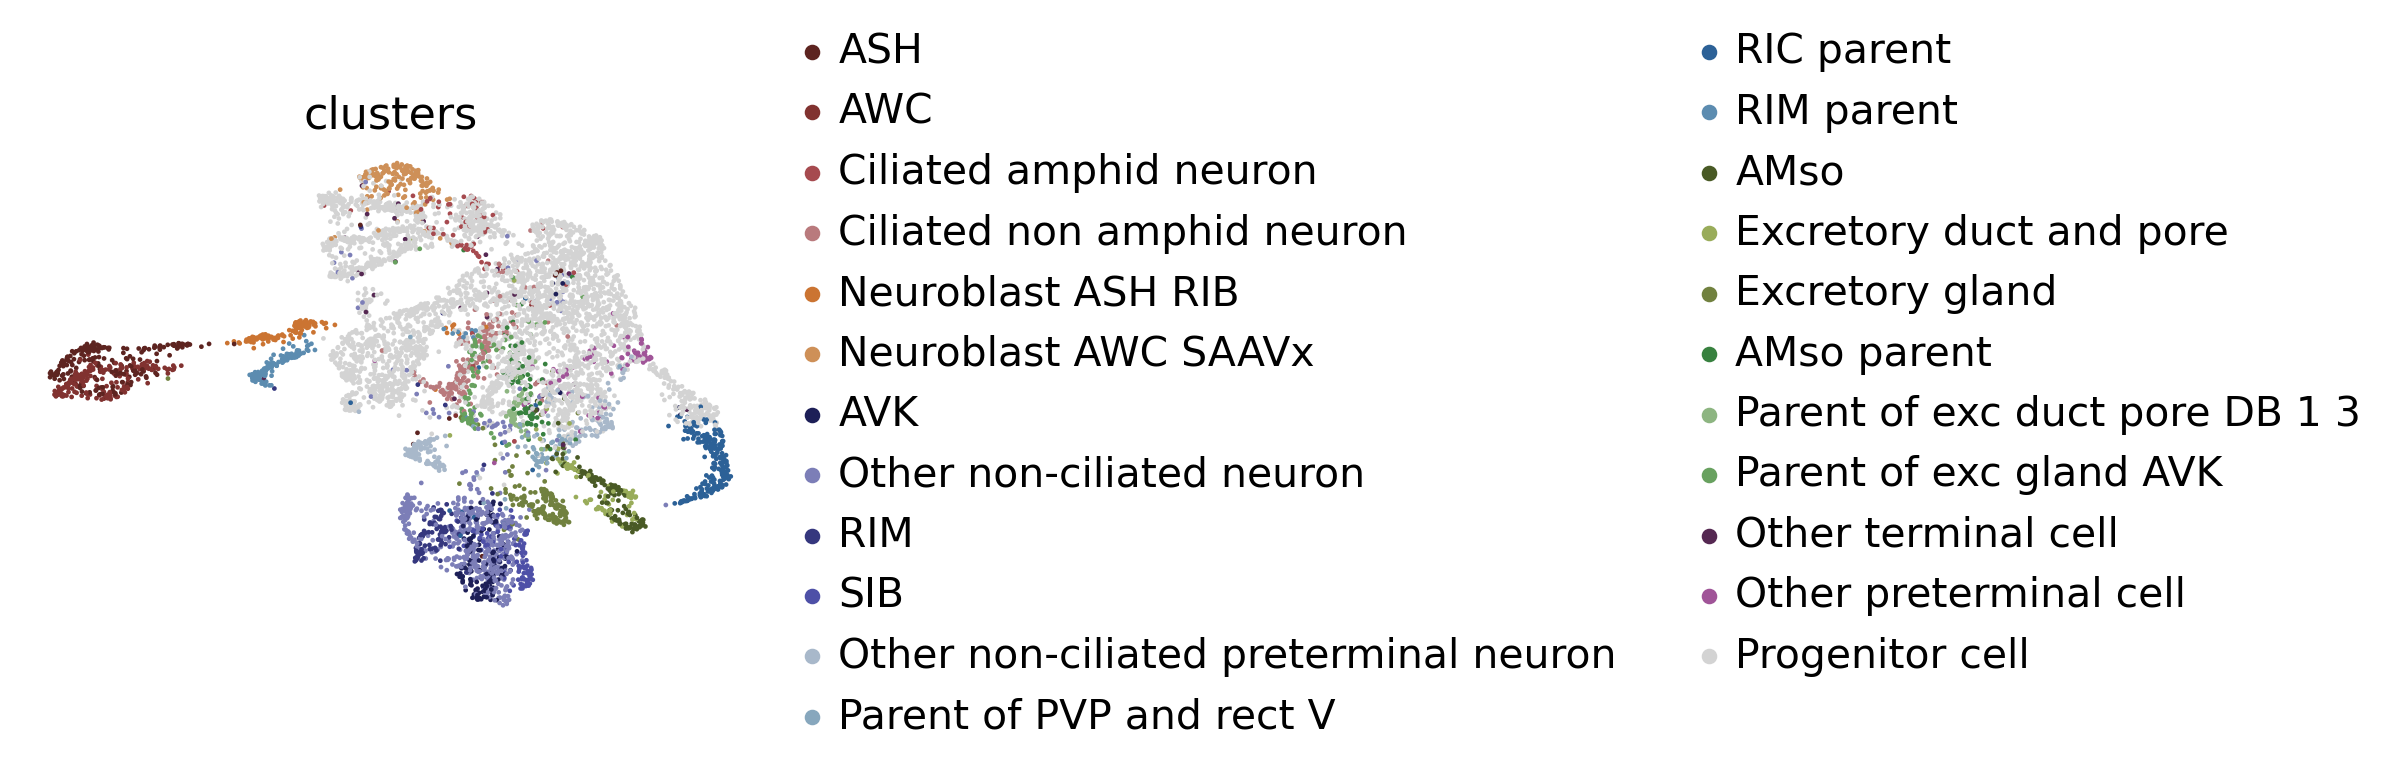

In [38]:
scv.pl.scatter(adata, c=['clusters'], legend_loc='right')

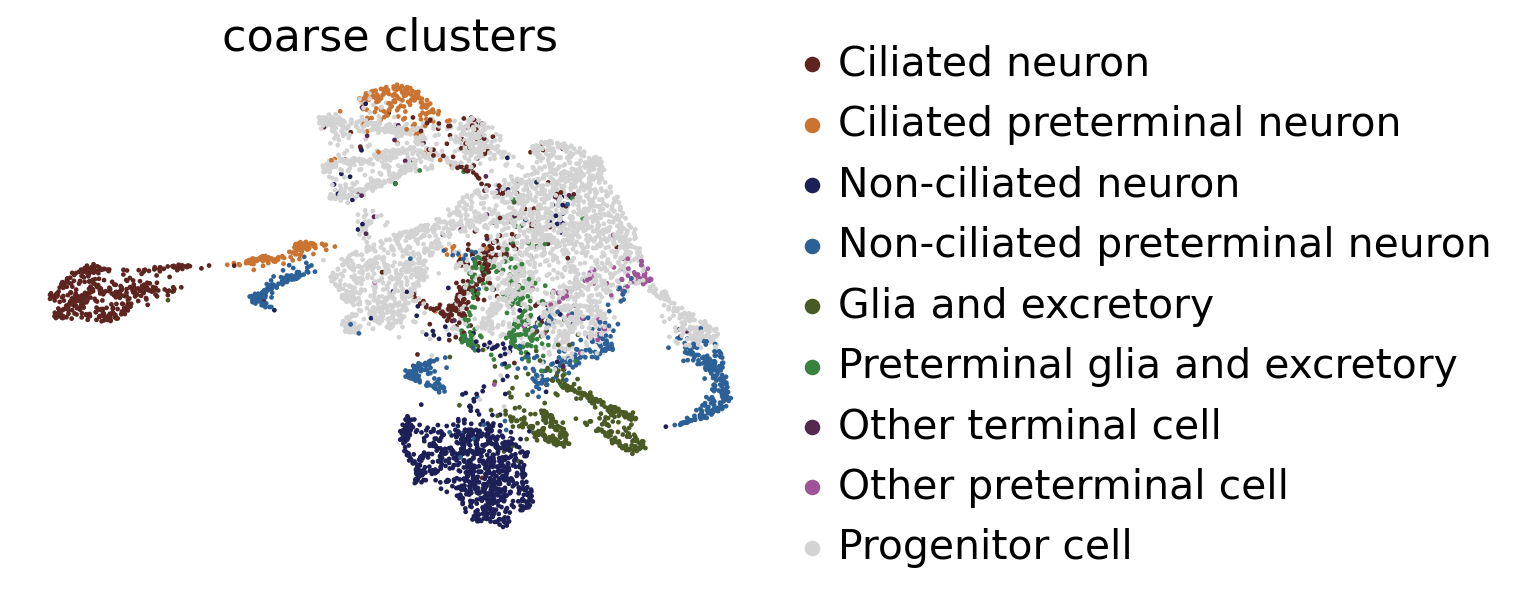

In [39]:
scv.pl.scatter(adata, c=['coarse_clusters'], legend_loc='right')

## Compute the couplings

### Run all methods

In [40]:
methods = np.unique(grid_df['kind'])
methods

array(['GW', 'LineageOT', 'OT', 'moslin'], dtype=object)

In [41]:
# prepare results dict
results = {}

# iterate over all methods
for method in methods:
    hyper_df = utils.get_best_runs(
        df=grid_df, 
        lineage_info=LINEAGE_INFO, 
        group_key="kind", 
        group=method, 
        converged=True
    )
    
    # extract hyperparameters from gridsearch results
    params = hyper_df.loc[hyper_df["tp"] == f"{EARLY_TP}-{LATE_TP}"]
    alpha = params["alpha"].values[0]
    epsilon = params["epsilon"].values[0]
    scale_cost = params["scale_cost"].values[0]
    max_inner_iterations = params["max_inner_iterations"].values[0]

    # print these parameters and run moslin
    print(f"{EARLY_TP=}, {LATE_TP=}, {epsilon=}, {alpha=} {scale_cost=} {max_inner_iterations=} {method=}")

    # run the corresponding method
    if method in ["moslin", "OT", "GW"]:
            prob, pred, conv, gt = utils.benchmark_moscot(
                adata=adata,
                early_time=EARLY_TP,
                late_time=LATE_TP,
                alpha=alpha,
                epsilon=epsilon,
                scale_cost=scale_cost,
                max_inner_iterations=int(max_inner_iterations),
                reorder_clusters=True,
            )
    elif method == "LineageOT":
        pred, conv, gt = utils.benchmark_lot(
            adata=adata,
            early_time=EARLY_TP,
            late_time=LATE_TP,
            epsilon=epsilon,
            scale_cost=scale_cost,
        ) 
        prob = None
    else:
        raise ValueError(f"Unrecognized method: {method}")

    # make sure this converged
    assert(conv), f" Method {method} did not converge. "

     # compute early and late errors
    early_cost = gt.cost(pred, late=False)
    late_cost = gt.cost(pred, late=True)
    mean_error = (early_cost + late_cost) / 2
    print(f"{mean_error=}")

    # save the results
    results[method] = {
        'coupling_matrix': pred,
        'converged': conv,
        'mean_error': mean_error,
        'prob': prob,
        'ground_truth': gt,
    }

Removing 0/30 not converged runs.
EARLY_TP=330, LATE_TP=390, epsilon=0.001, alpha=1.0 scale_cost='mean' max_inner_iterations=30000.0 method='GW'
INFO     Ordering Index(['AAACCTGAGACAATAC-400.2.3', 'AAACCTGAGATCCCGC-b01',                                       
                'AAACCTGTCACCCTCA-300.1.1', 'AAACCTGTCATTGCCC-400.2.2',                                            
                'AAACCTGTCTTACCTA-400.2.2', 'AAACGGGGTGCTCTTC-400.2.2',                                            
                'AAACGGGTCGGATGGA-300.1.1', 'AAACGGGTCTTGCCGT-r17',                                                
                'AAAGATGAGAATTGTG-400.2.2', 'AAAGATGAGACATAAC-400.2.3',                                            
                ...                                                                                                
                'TTTACTGAGTGTTAGA-400.2.1', 'TTTACTGCATACTACG-r17',                                                
                'TTTACTGCATCCAACA-400.2.3',

/cluster/project/treutlein/USERS/mlange/mambaforge/envs/moslin_2/lib/python3.11/site-packages/lineageot/evaluation.py:159: UserWarning: Expanded coupling not computed correctly. Check for infeasibility in row and column OT calculations. Updating the python optimal transport package may help (https://github.com/PythonOT/POT/issues/93).
If total mass - 1 is small, this may not significantly affect downstream results.
Total mass - 1: 2.0288180191174732e-05
  warnings.warn(("Expanded coupling not computed correctly. " +
/cluster/project/treutlein/USERS/mlange/mambaforge/envs/moslin_2/lib/python3.11/site-packages/lineageot/evaluation.py:159: UserWarning: Expanded coupling not computed correctly. Check for infeasibility in row and column OT calculations. Updating the python optimal transport package may help (https://github.com/PythonOT/POT/issues/93).
If total mass - 1 is small, this may not significantly affect downstream results.
Total mass - 1: 2.0288180190952687e-05
  warnings.warn(("Ex

mean_error=0.6239433022724727
Removing 10/240 not converged runs.
EARLY_TP=330, LATE_TP=390, epsilon=0.001, alpha=0.98 scale_cost='mean' max_inner_iterations=30000.0 method='moslin'
INFO     Ordering Index(['AAACCTGAGACAATAC-400.2.3', 'AAACCTGAGATCCCGC-b01',                                       
                'AAACCTGTCACCCTCA-300.1.1', 'AAACCTGTCATTGCCC-400.2.2',                                            
                'AAACCTGTCTTACCTA-400.2.2', 'AAACGGGGTGCTCTTC-400.2.2',                                            
                'AAACGGGTCGGATGGA-300.1.1', 'AAACGGGTCTTGCCGT-r17',                                                
                'AAAGATGAGAATTGTG-400.2.2', 'AAAGATGAGACATAAC-400.2.3',                                            
                ...                                                                                                
                'TTTACTGAGTGTTAGA-400.2.1', 'TTTACTGCATACTACG-r17',                                                
      

Make sure all ground-truth couplings are actually the same

In [42]:
assert((results['GW']['ground_truth'].coupling == results['OT']['ground_truth'].coupling).all()), "Mismatch for GW vs. OT"
assert((results['OT']['ground_truth'].coupling == results['LineageOT']['ground_truth'].coupling).all()), "Mismatch for OT vs. LineageOT"
assert((results['LineageOT']['ground_truth'].coupling == results['moslin']['ground_truth'].coupling).all()), "Mismatch for LineageOT vs. moslin"
assert((results['moslin']['ground_truth'].coupling == results['GW']['ground_truth'].coupling).all()), "Mismatch for moslin vs. GW"

Make sure all problem AnnData's are actually the same (recall we don't get this for LineageOT). 

In [43]:
assert((results['GW']['prob'].adata.obs_names == results['OT']['prob'].adata.obs_names).all()), "Mismatch for GW vs. OT"
assert((results['OT']['prob'].adata.obs_names == results['moslin']['prob'].adata.obs_names).all()), "Mismatch for OT vs. LineageOT"
assert((results['moslin']['prob'].adata.obs_names == results['GW']['prob'].adata.obs_names).all()), "Mismatch for moslin vs. GW"

Designate a ground-truth coupling, and an AnnData object to continue with (they are all the same). 

In [44]:
gt = results['moslin']['ground_truth']
adata_mos = results['moslin']['prob'].adata

### Look into embeddings

Let's look into the distribution over cell types at either time point

saving figure to file /cluster/project/treutlein/USERS/mlange/github/moslin_analysis_2/figures/packer_c_elegans/zoom_in/umap_330_390_clusters.pdf


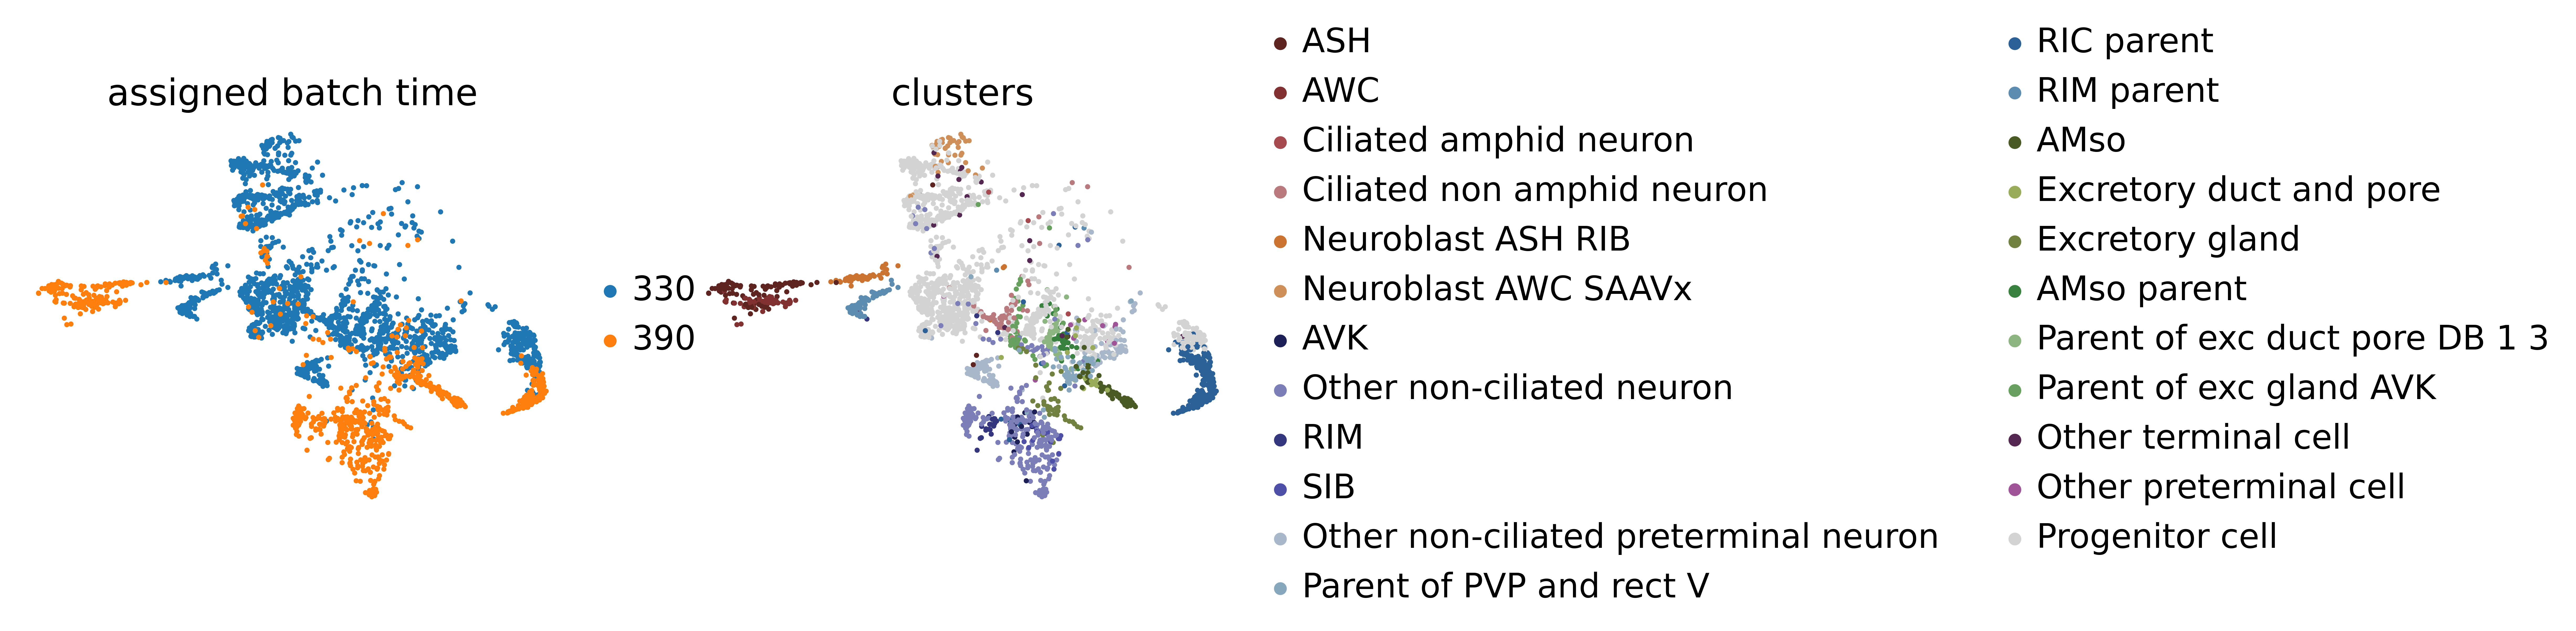

In [45]:
# get early and late representations
early_mask = adata_mos.obs[TIME_KEY] == EARLY_TP
late_mask = adata_mos.obs[TIME_KEY] == LATE_TP

fig_kwargs = {}
if save_figure:
    fig_kwargs["save"] = "umap_330_390_clusters.pdf"

scv.pl.scatter(adata_mos, c=[TIME_KEY, "clusters"], legend_loc='right', dpi=DPI_SAVE,  **fig_kwargs)

Show pie charts

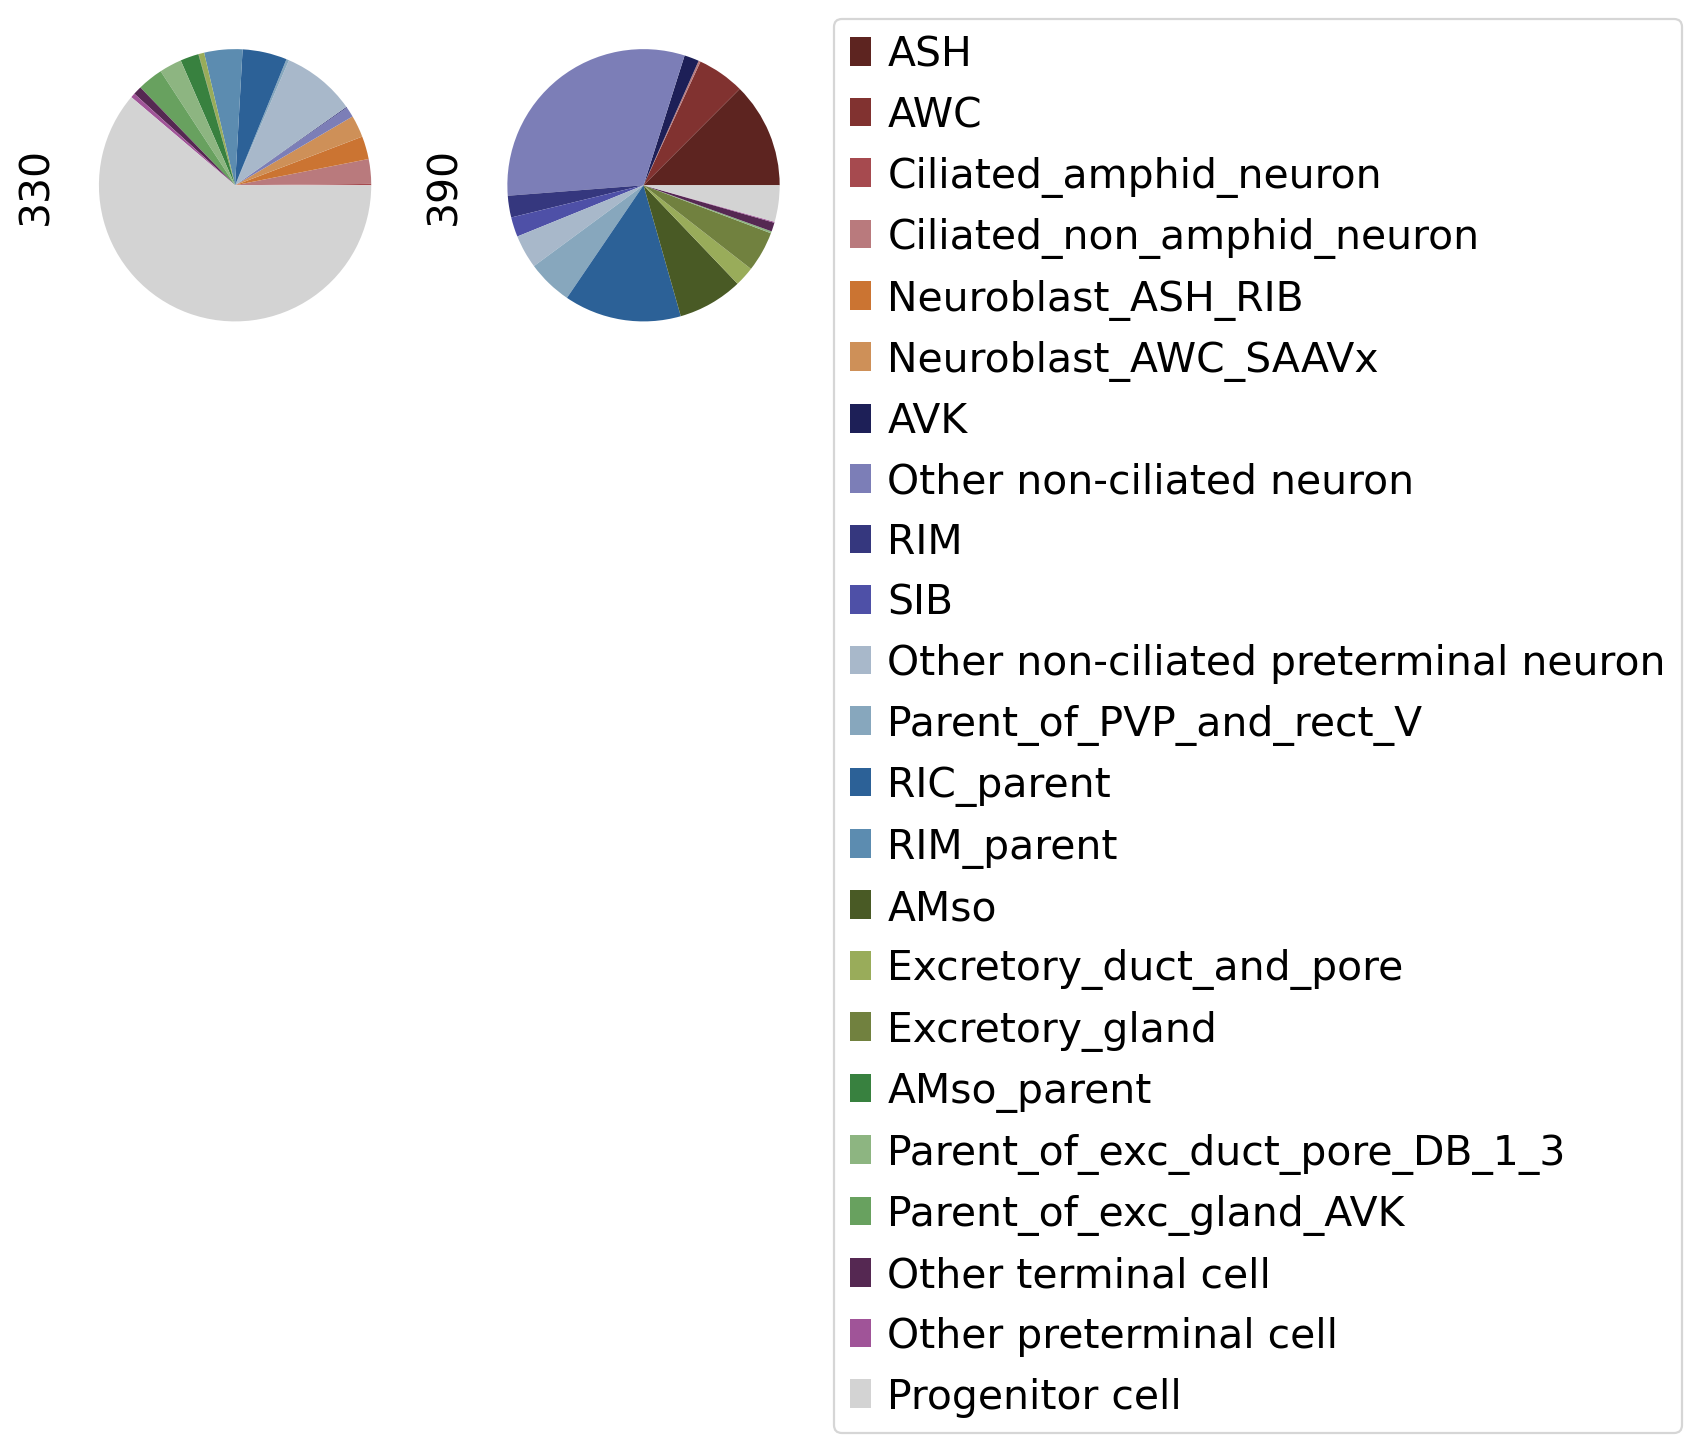

In [46]:
df = adata_mos.obs.groupby(["clusters", TIME_KEY]).size().unstack()
ax = df.plot.pie(subplots=True, labels=None, legend=None, colors=adata_mos.uns['clusters_colors'])

plt.legend(df.index, bbox_to_anchor=(1, 1.05))

plt.show()

## Visualize ancestor distributions

### Prepare GT and LineageOT problems

Create dummy moscot problems for GT and LineageOT, to facility easy plotting. 

In [47]:
prob_lot, _, _, _ = utils.benchmark_moscot(
                adata=adata,
                early_time=EARLY_TP,
                late_time=LATE_TP,
                alpha=0,
                epsilon=0.5,
                scale_cost="mean",
                max_inner_iterations=100,
                reorder_clusters=True,
)

prob_gt, _, _, _ = utils.benchmark_moscot(
                adata=adata,
                early_time=EARLY_TP,
                late_time=LATE_TP,
                alpha=0,
                epsilon=0.5,
                scale_cost="mean",
                max_inner_iterations=100,
                reorder_clusters=True,
)

INFO     Ordering Index(['AAACCTGAGACAATAC-400.2.3', 'AAACCTGAGATCCCGC-b01',                                       
                'AAACCTGTCACCCTCA-300.1.1', 'AAACCTGTCATTGCCC-400.2.2',                                            
                'AAACCTGTCTTACCTA-400.2.2', 'AAACGGGGTGCTCTTC-400.2.2',                                            
                'AAACGGGTCGGATGGA-300.1.1', 'AAACGGGTCTTGCCGT-r17',                                                
                'AAAGATGAGAATTGTG-400.2.2', 'AAAGATGAGACATAAC-400.2.3',                                            
                ...                                                                                                
                'TTTACTGAGTGTTAGA-400.2.1', 'TTTACTGCATACTACG-r17',                                                
                'TTTACTGCATCCAACA-400.2.3', 'TTTCCTCCAATAGAGT-400.2.2',                                            
                'TTTCCTCGTACAGTTC-400.2.3', 'TTTGCGCTCGGTTCGG-500.1.1', 

Next, take the solved couplings and insert them into the dummy problems. 

In [48]:
prob_lot[330, 390].set_solution(results['LineageOT']['coupling_matrix'], overwrite=True)

prob_gt[330, 390].set_solution(gt.coupling, overwrite=True)

BirthDeathProblem[stage='solved', shape=(1874, 855)]

Verify that this worked

In [49]:
assert((results['LineageOT']['coupling_matrix'] == prob_lot[330, 390].solution.transport_matrix).all()), "Setting the LOT solution failed"

assert((gt.coupling == prob_gt[330, 390].solution.transport_matrix).all()), "Setting the ground truth solution failed"

Write these to the results dict

In [50]:
results['LineageOT']['prob'] = prob_lot
results['gt'] = {'prob': prob_gt}

### Show in embeddings

Change the order of entries in the results dict. 

In [51]:
new_order = ['gt', 'LineageOT', 'OT', 'GW', 'moslin']
results = {key: results[key] for key in new_order}

Visualize where different methods predict RIM cells to come from. 

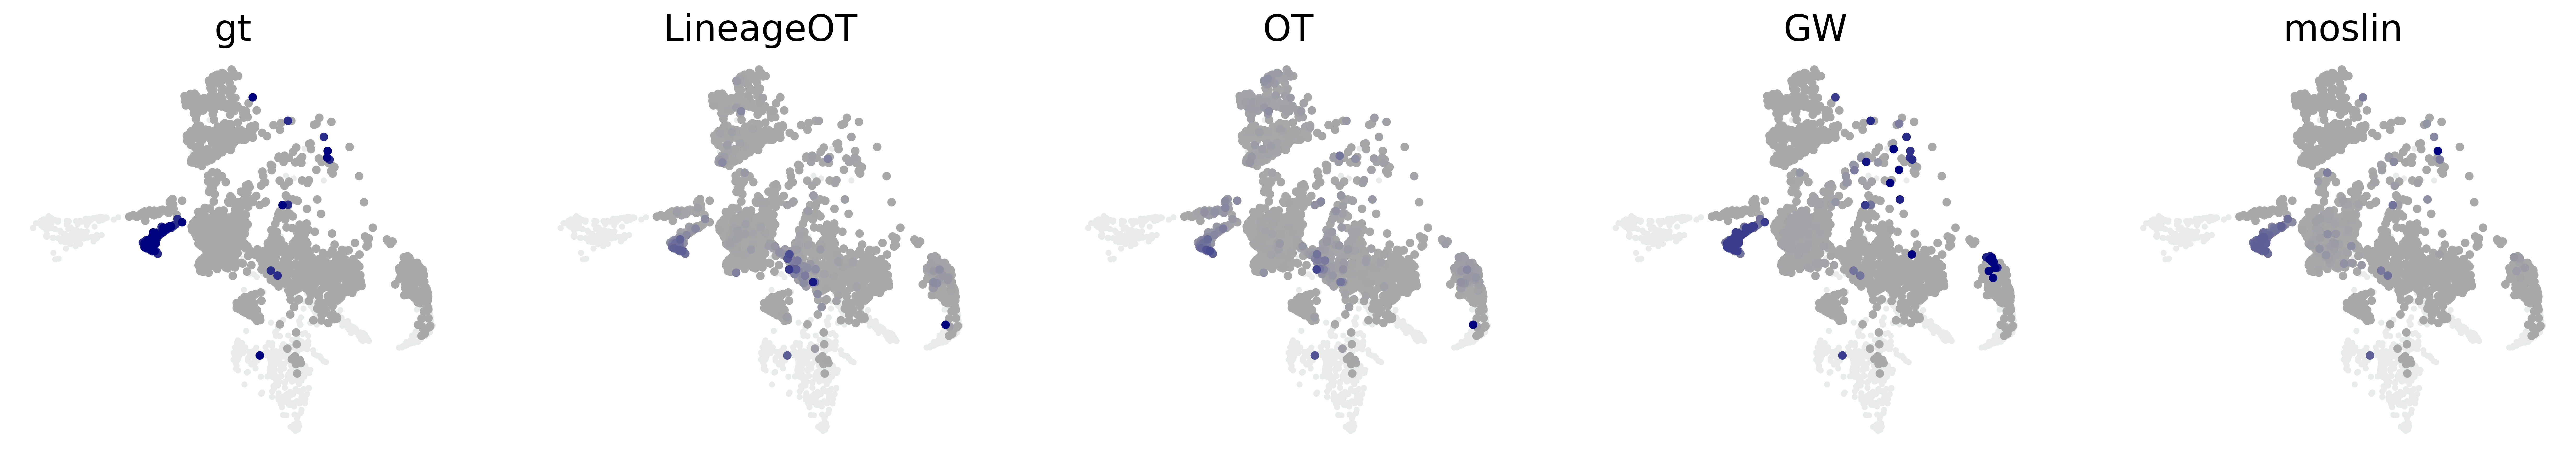

In [52]:
# define the target state
tgt_state = 'RIM'

# initialize an empty DataFrame for the results
adata_src = results['moslin']['prob'][EARLY_TP, LATE_TP].adata_src.copy()
pull_df = pd.DataFrame(index=adata_src.obs_names.copy(), columns=results.keys())

# set up figure and axes
n_panels = len(results)
fig, axes = plt.subplots(1, n_panels, figsize=(5 * n_panels, 4), dpi=DPI_SAVE)

# iterate over methods, use their solved problems to compute the pull of the target state
for i, (method, value_dict) in enumerate(results.items()):

    # get the corresponpding problem
    ot_problem = value_dict['prob']

    # compute the pull distribution
    ot_problem.pull(source=EARLY_TP, target=LATE_TP, data='clusters', subset=tgt_state)

    # extract it from the problem
    pull_df[method] = ot_problem[EARLY_TP, LATE_TP].adata_src.obs['pull'].copy()

    # plot in the umap
    axes[i] = mtp.pull(
        ot_problem,
        time_points=[330],
        basis="umap",
        ax=axes[i],
        return_fig=True,
        title=[f"{method}"], 
        frameon=False, 
        colorbar_loc=None,
    )

# insert into an AnnData object
pdata = AnnData(X=pull_df, obs=adata_src.obs.copy())

# put cluster information into the DataFrame
pull_df['clusters'] = adata_src.obs['clusters'].copy()

if save_figure:
    plt.savefig(FIG_DIR / "umap_ancestor_error.pdf", bbox_inches="tight")

Pie charts over the ancestor mass distribution

/scratch/tmp.50943645.mlange/ipykernel_36810/218625426.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df.plot.pie(subplots=True, labels=None, legend=None, colors=adata_src.uns['clusters_colors'], ax=ax)


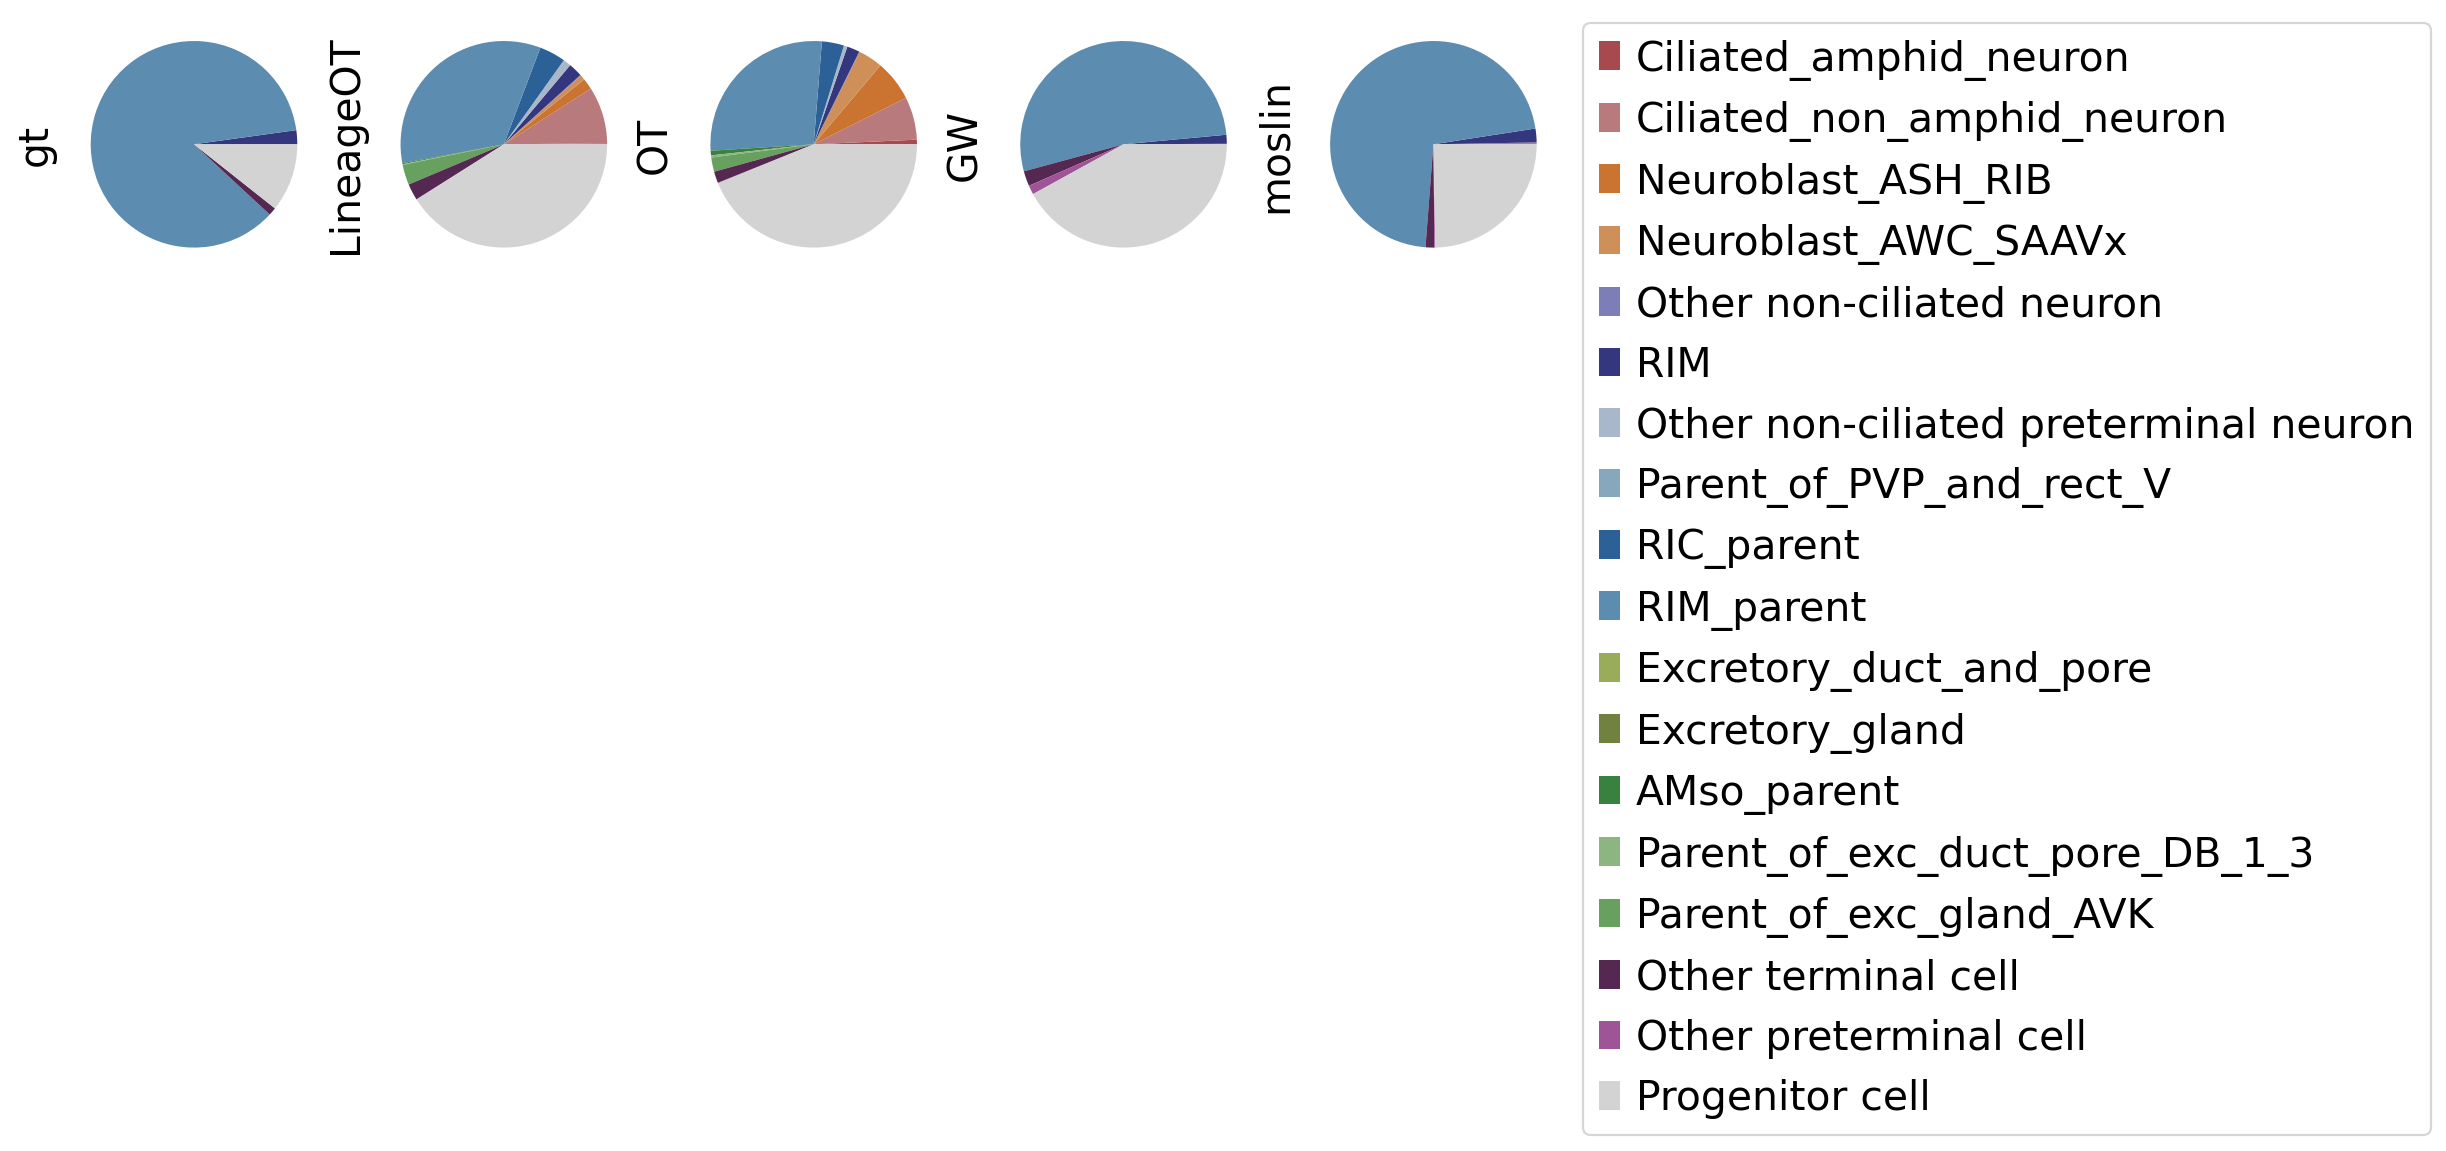

In [53]:
fig, ax = plt.subplots(figsize=(12, 3))

df = pull_df.groupby('clusters').sum()
df.plot.pie(subplots=True, labels=None, legend=None, colors=adata_src.uns['clusters_colors'], ax=ax)

plt.legend(df.index, bbox_to_anchor=(1., 1.05))

if save_figure:
    plt.savefig(FIG_DIR / "pie_charts_ancestor_distribution.pdf", bbox_inches="tight")

plt.show()

### Compute ancestor/descendant errors

Compute error metrics for LineageOT. 

In [54]:
anc_lot, des_lot = compute_errors(results['LineageOT']['coupling_matrix'], gt, scale_by_marginal=False)

100%|██████████| 1874/1874 [00:07<00:00, 242.81it/s]


Compute error metrics for moslin. 

In [55]:
anc_mos, des_mos = compute_errors(results['moslin']['coupling_matrix'], gt, scale_by_marginal=False)

100%|██████████| 1874/1874 [00:05<00:00, 315.28it/s]


Write the resulting errors, and differences in erorrs, back to AnnData

In [56]:
# write the error for LineageOT
adata_mos.obs["lot_error"] = anc_lot + des_lot  # assumes t1 < t2 always
adata_mos.obs["lot_early_error"] = np.nan
adata_mos.obs.loc[
    adata_mos.obs_names[(adata_mos.obs[TIME_KEY] == LATE_TP)], "lot_early_error"
] = anc_lot
adata_mos.obs["lot_late_error"] = np.nan
adata_mos.obs.loc[
    adata_mos.obs_names[(adata_mos.obs[TIME_KEY] == EARLY_TP)], "lot_late_error"
] = des_lot

# write the error for moslin
adata_mos.obs["moslin_error"] = anc_mos + des_mos  # assumes t1 < t2 always
adata_mos.obs["moslin_early_error"] = np.nan
adata_mos.obs.loc[
    adata_mos.obs_names[(adata_mos.obs[TIME_KEY] == LATE_TP)], "moslin_early_error"
] = anc_mos
adata_mos.obs["moslin_late_error"] = np.nan
adata_mos.obs.loc[
    adata_mos.obs_names[(adata_mos.obs[TIME_KEY] == EARLY_TP)], "moslin_late_error"
] = des_mos

# compute the difference in errors, for ancestors and descendants.
adata_mos.obs["diff_error"] = adata_mos.obs["lot_error"] - adata_mos.obs["moslin_error"]
adata_mos.obs["diff_early_error"] = (
    adata_mos.obs["lot_early_error"] - adata_mos.obs["moslin_early_error"]
)
adata_mos.obs["diff_late_error"] = (
    adata_mos.obs["lot_late_error"] - adata_mos.obs["moslin_late_error"]
)

## Visualize the zoom in

### Visualize the ancestor and descendant error

Plot the actual error differences in the UMAP. 

/cluster/project/treutlein/USERS/mlange/mambaforge/envs/moslin_2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(
/cluster/project/treutlein/USERS/mlange/mambaforge/envs/moslin_2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:371: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  ax.scatter(
/cluster/project/treutlein/USERS/mlange/mambaforge/envs/moslin_2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:381: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  ax.scatter(
/cluster/project/treutlein/USERS/mlange/mambaforge/envs/moslin_2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = sca

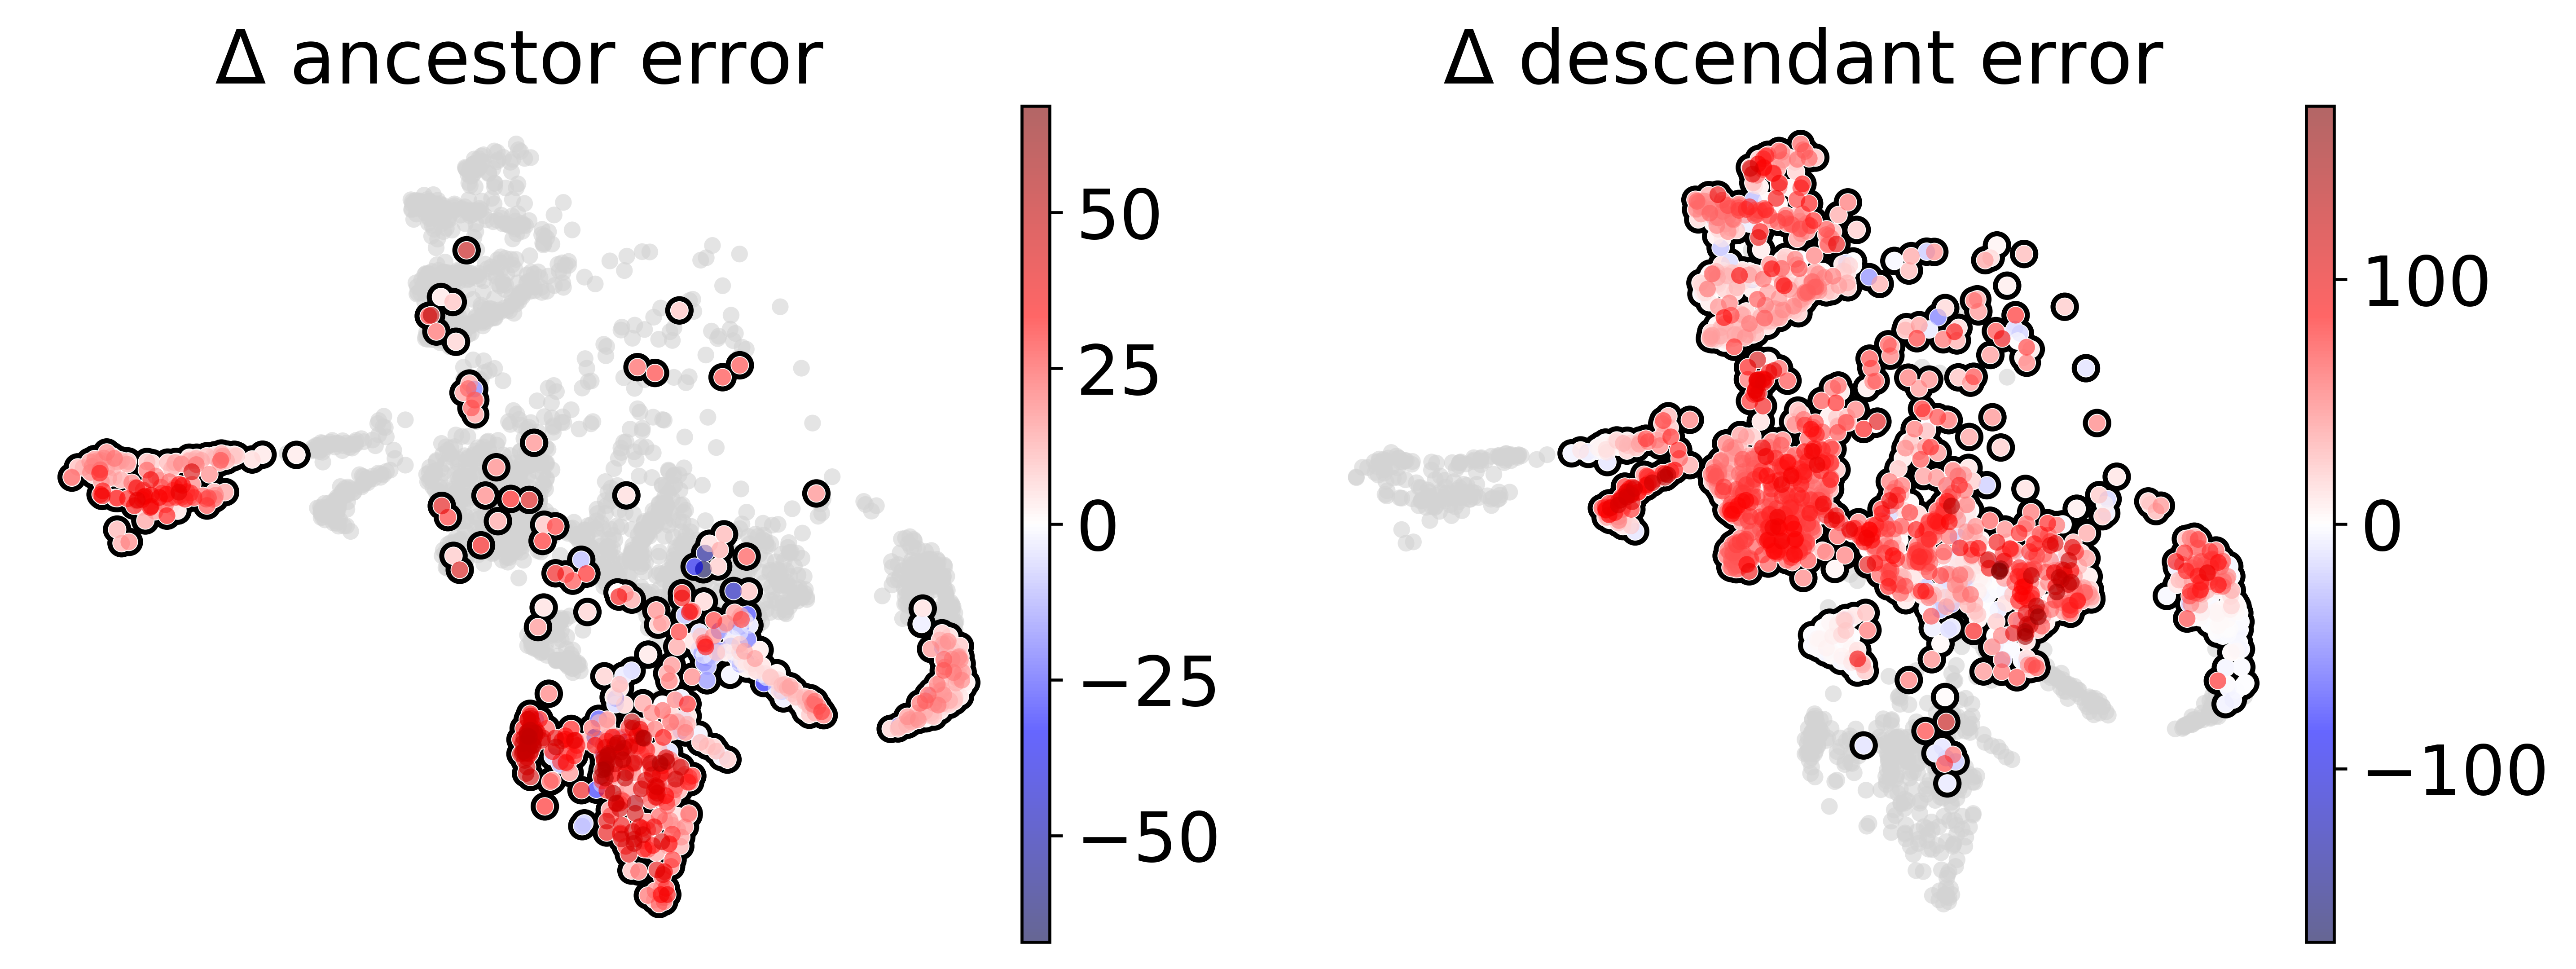

In [57]:
fig_kwargs = {}
if save_figure:
    fig_kwargs["save"] = "umap_delta_error.pdf"

fig = plot_ancestor_descendant_error(adata_mos, **fig_kwargs)

### Visualize coupling for target population

I would like to focus on the `RIM_parent` population: 

In [58]:
target = "RIM_parent"
# mask_1 = adata_mos.obs["plot.cell.type"] == target
mask_1 = adata_mos.obs["clusters"] == target

adata_mos[mask_1].obs["lineage"].value_counts()

lineage
ABpxppaapa    80
ABpxpapapa     2
ABpxpaappa     1
ABpxpapaaa     1
ABpxpapap      1
Name: count, dtype: int64

Let's define a second mask to fix the major lineage here:

In [59]:
mask_2 = adata_mos.obs["lineage"] == "ABpxppaapa"

mask = np.logical_and(mask_1, mask_2)
np.sum(mask)

80

Highlight these cells on the umap: 

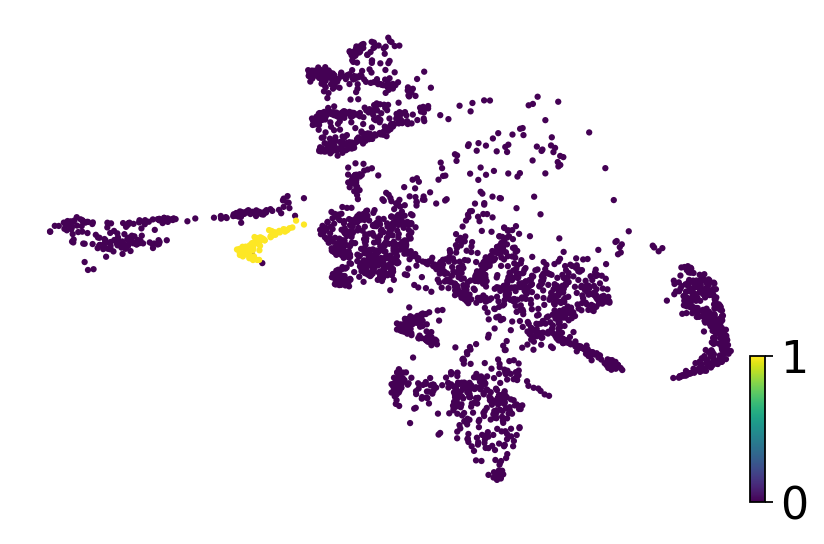

In [60]:
scv.pl.scatter(adata_mos, c=mask, color_map="viridis")

Visualize the ground-truth, and moslin/LineageOT-predicted couplings for this target population. 

In [61]:
methods = ['LineageOT', 'OT', 'GW', 'moslin']

Using the mask for subsetting
Using the mask for subsetting
Using the mask for subsetting
Using the mask for subsetting
Using the mask for subsetting


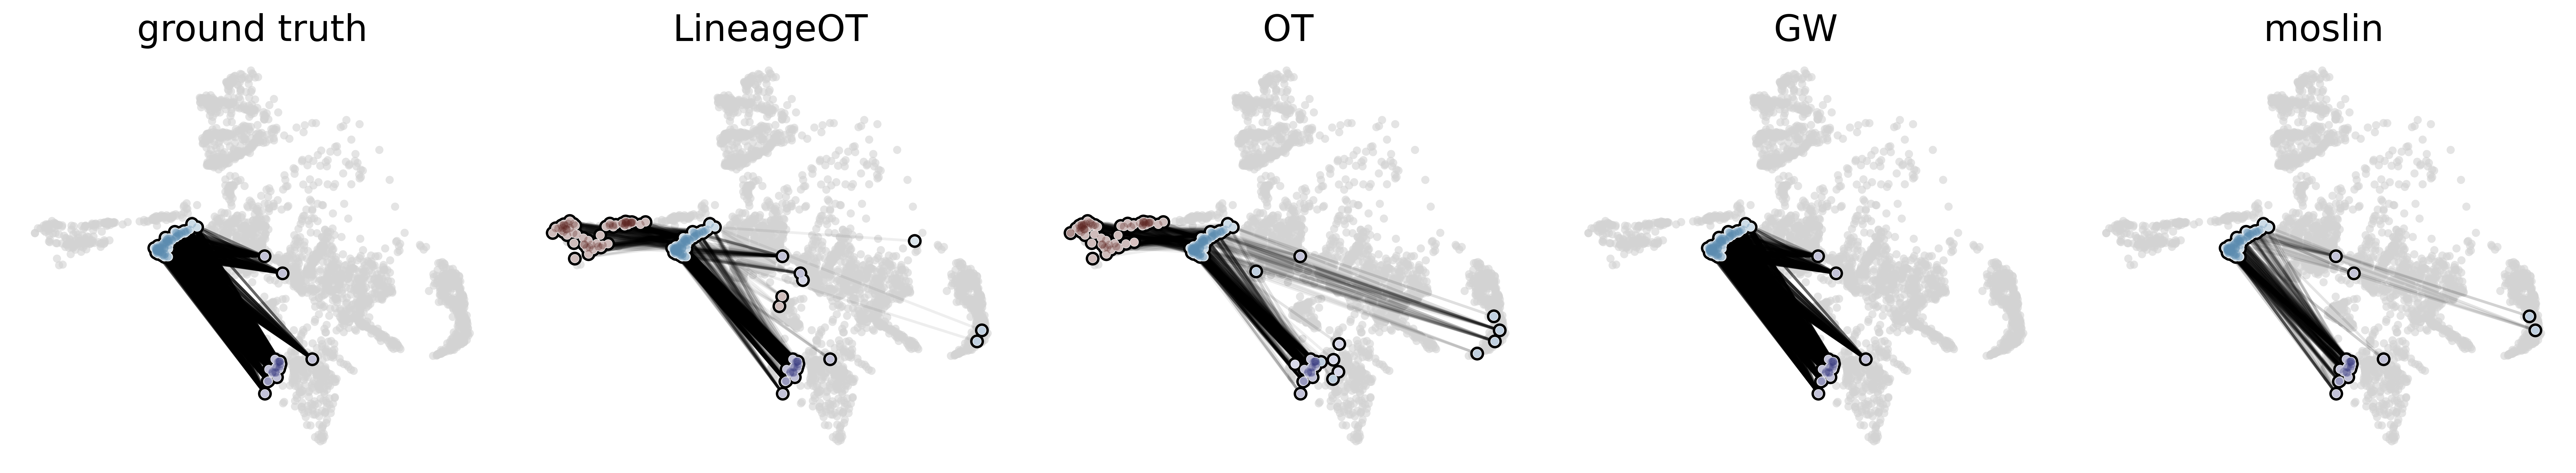

In [62]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=UserWarning)

    thr = 0.1
    alpha_scale = 0.1

    # set up the figure with subplots
    n_panels = len(methods) + 1
    fig, axes = plt.subplots(1, n_panels, figsize=(4 * n_panels, 4), dpi=DPI_SAVE)
    
    common_kwargs = {"mask": mask, "thr": thr, "dot_color": "clusters", "alpha_scale": 0.6}

    # plot the ground truth coupling
    plot_coupling(adata_mos, gt.coupling, ax=axes[0], **common_kwargs)
    axes[0].set_title("ground truth")
    
    for i, method in enumerate(methods):
        plot_coupling(adata_mos, results[method]['coupling_matrix'], ax=axes[i+1], **common_kwargs)
        axes[i+1].set_title(method)
    
    fig.tight_layout()
    
    if save_figure:
        plt.savefig(FIG_DIR / "umap_couplings.pdf")

### Quantify descendant error over subpopulation

Quantify the mean descendant error over the `RIM_parent` population. Check that our mask still points to the correct set of cells. 

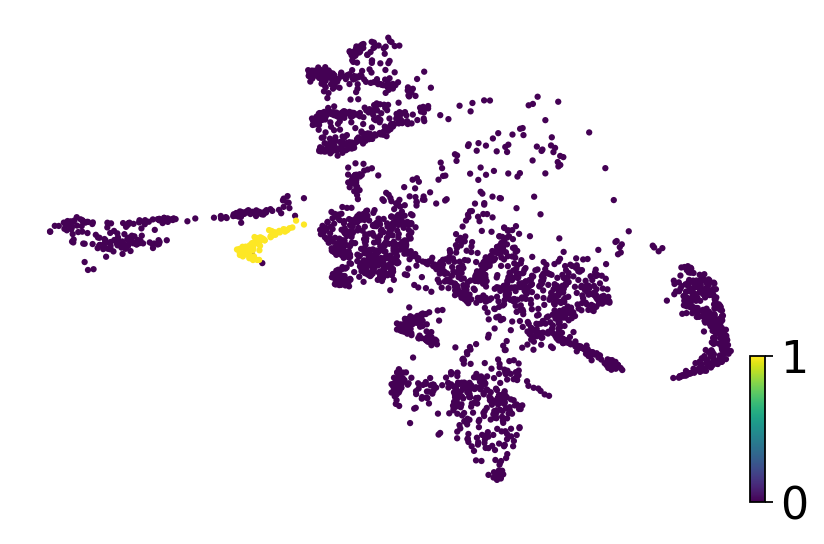

In [63]:
scv.pl.scatter(adata_mos, c=mask, color_map="viridis")

Restrict the target-population mask to early cells

In [64]:
# get a mask for early cells
src_mask = adata_mos.obs[TIME_KEY] == EARLY_TP

# check that this maches the number of rows in the predicted couplings
assert (
    np.sum(src_mask) == results['moslin']['coupling_matrix'].shape[0] == results['LineageOT']['coupling_matrix'].shape[0]
), "Shape mismatch between prediction and AnnData"

# subset the target mask to early cells
final_mask = mask[src_mask]

Re-compute descendant errors using marginal-scaling. 

In [65]:
methods

['LineageOT', 'OT', 'GW', 'moslin']

In [66]:
descendant_errors = {}

# compute the descendant error using an uninformative, independend couplint
_, des_error_ind = compute_errors(gt.ind_coupling, gt, scale_by_marginal=True)

# iterate over all other methods
for method in methods:

    # compute descendant errors by iterating over all early cells
    _, des_error = compute_errors(results[method]['coupling_matrix'], gt, scale_by_marginal=True)

    # normalize using the independent couplint
    descendant_errors[method] = np.mean(np.array(des_error)[final_mask]) / np.mean(
        np.array(des_error_ind)[final_mask]
    ) 

100%|██████████| 1874/1874 [00:06<00:00, 290.08it/s]


Display these errors. 

In [67]:
descendant_errors

{'LineageOT': 0.7981581412720488,
 'OT': 0.8460224176397144,
 'GW': 0.36695491656620927,
 'moslin': 0.26153473528579}

Sanity check, compute the error when using ground truth. 

In [68]:
# compute descendant errors by iterating over all early cells
_, des_error = compute_errors(gt.coupling, gt, scale_by_marginal=True)

100%|██████████| 1874/1874 [00:03<00:00, 526.97it/s]


In [69]:
np.mean(np.array(des_error)[final_mask])

0.0

As expected, this is zero. 